<a href="https://colab.research.google.com/github/sdrangan/introml-soln/blob/master/unit08_svm/lab_emnist_soln.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab: SVMs on Extended MNIST

In the [MNIST demo](demo06_mnist_svm.ipynb), we saw how SVMs can be used for the classic MNIST problem of digit recognition. In this lab, we are going to extend the MNIST dataset by adding non-digit letters and see if the classifier can distinguish the digits from the non-digits. All non-digits will be lumped as a single 11-th class. This is a highly simplified version of a full character classification, but will illustrate some concepts.

In addition to the concepts in the demo, you will learn:
* Select the SVM parameters (`C` and `gamma`) via cross-validation.
* Use the `GridSearchCV` method to search for parameters with cross-validation.


As usual, we download the standard packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, preprocessing

## Downloading the EMNIST data

The EMNIST data can be downloaded from `pytorch` as follows.  The initial download is 562 MB, so it may take a little while.  On Google colab, it will be in less than a minute.

Note:  In an earlier version of the lab, you directly downloaded the data from the [EMNIST](https://www.nist.gov/itl/products-and-services/emnist-dataset), but the dataset appears to have been removed.

In [48]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Define the transform to convert the images to tensors
transform = transforms.Compose([transforms.ToTensor()])

# Download the EMNIST dataset
emnist_dataset = datasets.EMNIST(root='./data', split='balanced', train=True, transform=transform, download=True)

You can then convert the data to numpy arrays as follows.  
*  `Xtr` is `(ntr,28,28)` the training data array representing `28x28` images with `ntr` samples.
* `ytr[i]` is the integer label from 0 to `nclasses-1`.
When `ytr[i] = k` it corresponds to the string digit n `classes[k]`.

In [11]:
Xtr = emnist_dataset.train_data.numpy()
ytr = emnist_dataset.targets.numpy()
Xts = emnist_dataset.train_data.numpy()
yts = emnist_dataset.targets.numpy()
classes = emnist_dataset.classes

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [12]:
# TODO:  Print the number of training and test samples
#   ntr = ...
#   nts = ...
ntr = Xtr.shape[0]
nts = Xts.shape[0]
print('Number of training samples = %d' % ntr)
print('Number of test samples = %d' % nts)

Number of training samples = 112800
Number of test samples = 112800


Print the classes.  You should see there are classes for:
* digits 0 to 9
* capital letters `A` to `Z`
* some lowercase letters: `a``, `b`, `d`, `e`, `f`, `g`, `h`, `n`, `q`, `r`, `t`

Not all lowercase letters are included since they may be too easy to confuse with the uppercase.

In [13]:
# TODO:  Print the classes and the total number of classes
#  print(classes)
#  nclasses = ...
print(classes)
nclasses = len(classes)
print('Total number of classes = %d' % nclasses)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']
Total number of classes = 47


## Displaying the Characters

We will use the function from the demo to plot the characters.  Note that the `label` argument takes either `None` or a string, not a decimal.

In [7]:
def plt_digit(x,label=None):
    nrow = 28
    ncol = 28
    xsq = x.reshape((nrow,ncol))
    plt.imshow(xsq.T,  cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    if label:
        plt.title(label)

Plot 8 random samples from the training data.  You can use the `plt_digit` function above with `subplot` to create a nice display.  You may want to size your plot with the `plt.figure(figsize=(10,20))` command.

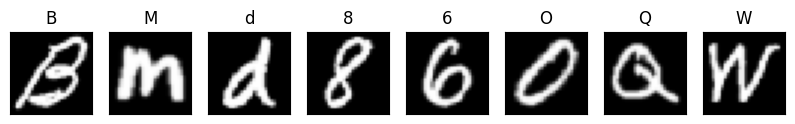

In [8]:
# TODO:  Plot 8 random samples from the training data of the digits
# Select random digits
nplt = 8
nsamp = Xtr.shape[0]
Iperm = np.random.permutation(nsamp)

# Plot the images using the subplot command
plt.figure(figsize=(10,20))
for i in range(nplt):
    ind = Iperm[i]
    plt.subplot(1,nplt,i+1)
    plt_digit(Xtr[ind], classes[ytr[ind]])

## Creating a Non-Digit Class


Before we begin, we first need to remove all the letters corresponding to `I`, `L` and `O` since they are too similar to the other characters.  Loop over the elements in `remove_list` and delete the rows of `Xtr`, `Xts`, `ytr`, and `yts` corresponding to these characters.

In [15]:
remove_list = ['I', 'L', 'O']

for r in remove_list:

    # TODO
    #  Delete rows in data where character corresponds to r
    ind = classes.index(r)
    I = np.where(ytr == ind)[0]
    Xtr = np.delete(Xtr, I, axis=0)
    ytr = np.delete(ytr, I)

    I = np.where(yts == ind)[0]
    Xts = np.delete(Xts, I, axis=0)
    yts = np.delete(yts, I)

SVM classifiers are VERY SLOW to train.  The training is particularly slow when there are a large number of classes, since the one classifier must be trained for each pair of labels.  To make the problem easier, we are going to lump all of the letters in one class and add that class to the digits.  

We can do this by creating a label for the non-digit class `npn_digit_class = 10`.  Then whenever `ytr[i] >= non_digit_class` we set `ytr[i] = non_digit_class`.  We do the same with `yts`.


In [16]:
non_digit_class = 10

# TODO
#  ytr = ...
#  yts = ...

ytr = np.minimum(ytr, non_digit_class)
yts = np.minimum(yts, non_digit_class)

Next, to reduce the training and test time, we will use only a small subset of the training and test data.  Of course, you will not get great results with this small dataset.  But, we can at least illustrate the basic concepts.  Create new training and test data `Xtr1`, `ytr1`, `Xts1` and `yts1` with a randomly selected sample of digits and non-digits shown.

In [35]:
# Number of training and test digits and letters
ntr_dig = 5000
ntr_let = 1000
nts_dig = 5000
nts_let = 1000

# TODO:
#   Xtr1, ytr1 = ...
Idig = np.where(ytr < non_digit_class)[0]
Ilet = np.where(ytr == non_digit_class)[0]
Idig1 = np.random.permutation(Idig)[:ntr_dig]
Ilet1 = np.random.permutation(Ilet)[:ntr_let]
I = np.hstack((Idig1,Ilet1))
Xtr1 = Xtr[I,:].copy()
ytr1 = ytr[I].copy()


# TODO:
#   Xt21, yt21 = ...
Idig = np.where(yts < non_digit_class)[0]
Ilet = np.where(yts == non_digit_class)[0]
Idig1 = np.random.permutation(Idig)[:ntr_dig]
Ilet1 = np.random.permutation(Ilet)[:ntr_let]
I = np.hstack((Idig1,Ilet1))
Xts1 = Xts[I,:].copy()
yts1 = yts[I].copy()

To confirm that selection worked, print

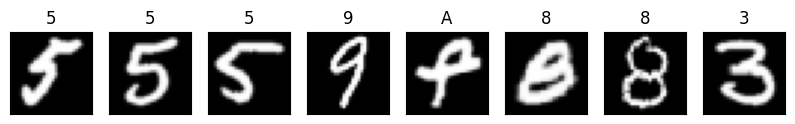

In [36]:
# TODO:  Plot 8 random samples from the training data of the digits
# Select random digits
nplt = 8
nsamp = Xtr1.shape[0]
Iperm = np.random.permutation(nsamp)

# Plot the images using the subplot command
plt.figure(figsize=(10,20))
for i in range(nplt):
    ind = Iperm[i]
    plt.subplot(1,nplt,i+1)
    plt_digit(Xtr1[ind], classes[ytr1[ind]])

The training data above takes values from 0 to 255.  Rescale the data from -1 to 1.  This will get slightly better performance on the SVM.  Save the scaled data into arrays `Xtr1` and `Xts1`.

In [37]:
from typing import NoReturn
# TODO:  Rescale the data from -1 to 1
# Xtr1 = ...
# Xts1 = ...
Xtr1 = 2*Xtr1/255.0 - 1
Xts1 = 2*Xts1/255.0 - 1

# TODO:  Reshape the arrays to (n, 28*28)
# Xtr1 = Xtr1.reshape(...)
# Xts1 = Xts1.reshape(...)
ntr1, nrow, ncol = Xtr1.shape
Xtr1 = Xtr1.reshape((ntr1, nrow*ncol))

nts1, nrow, ncol = Xts1.shape
Xts1 = Xts1.reshape((nts1, nrow*ncol))

## Run the SVM classifier

First create the SVM classifer. Use an `rbf` classifier with `C=2.8` and `gamma=.0073`. We will look at how to select these parameters laters.

In [38]:
from sklearn import svm

# TODO:  Create a classifier: a support vector classifier
# svc = ...
svc = svm.SVC(probability=False,  kernel="rbf", C=2.8, gamma=.0073, verbose=10)

Fit the classifier using the scaled training data.  SVMs are insanely slow to train.  But, in this lab, we have kept the training size very small. So, the fitting should take about a minute or two.

In [39]:
# TODO:  Fit the classifier on the training data.
svc.fit(Xtr1,ytr1)

[LibSVM]

SVC(C=2.8, gamma=0.0073, verbose=10)

Measure the accuracy on the test data.  This too will take another huge amount of time.  Print the accuracy.  If you did everything right, you should get an accuracy of around 89%.

In [41]:
# TODO:  Measure error on the test data
yhat = svc.predict(Xts1)
print(np.mean(yhat == yts1))

0.9068333333333334


The error rate is quite a bit higher than what we got in the digits only case.  Actually, had we done a classifier using all 36 labels instead of collapsing the letters to a single class, the SVM classifier would have done much better.  The reason is that the "letters" class is now extremely complex.  

Print a confusion matrix.  You should see that the error rate on the "letters" class is much higher.

[[0.971 0.    0.    0.    0.002 0.    0.002 0.    0.    0.    0.013]
 [0.    0.978 0.002 0.002 0.002 0.    0.    0.004 0.    0.    0.006]
 [0.    0.004 0.937 0.002 0.002 0.    0.    0.004 0.002 0.002 0.025]
 [0.004 0.004 0.006 0.937 0.    0.004 0.    0.007 0.006 0.002 0.015]
 [0.    0.    0.002 0.    0.921 0.    0.    0.    0.    0.017 0.031]
 [0.    0.002 0.    0.006 0.002 0.925 0.008 0.    0.002 0.004 0.026]
 [0.002 0.004 0.    0.    0.002 0.006 0.92  0.    0.    0.    0.033]
 [0.    0.002 0.002 0.    0.004 0.    0.    0.971 0.    0.013 0.003]
 [0.002 0.002 0.002 0.006 0.004 0.006 0.    0.    0.891 0.011 0.04 ]
 [0.    0.004 0.    0.004 0.014 0.    0.    0.011 0.002 0.935 0.014]
 [0.063 0.044 0.036 0.035 0.075 0.065 0.056 0.015 0.064 0.044 0.749]]


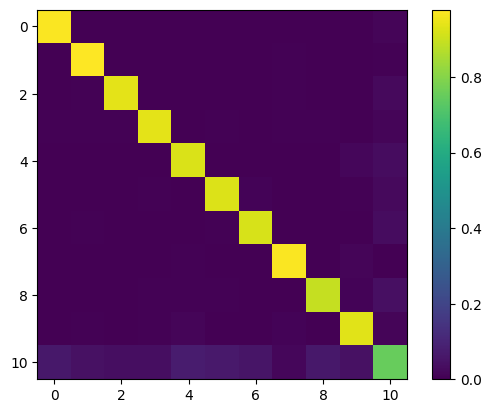

In [43]:
from sklearn.metrics import confusion_matrix

# TODO:  Print a confusion matrix
#  C = confusion_matrix(...)
C = confusion_matrix(yts1,yhat)

# TODO:  Normalize the confusion matrix so that each row sums to one
Csum = np.sum(C,1)
C = C / Csum[np.newaxis,:]

# Print the confusion matrix
print(np.array_str(C, precision=3, suppress_small=True))
plt.imshow(C, interpolation='none')
plt.colorbar()

Print:
* What fraction of digits are mislabeled as non-digits?  
* What fraction of letters are mislabeled as non-digits?

In [45]:
# TODO:  Print above two error rates
err1 = np.mean((yhat == 10) & (yts1 < 10))
err2 = np.mean((yhat < 10) & (yts1 == 10))

print('Digit -> letter error rate = %12.4e' % err1)
print('Letter -> digit error rate = %12.4e' % err2)

Digit -> letter error rate =   3.4333e-02
Letter -> digit error rate =   4.1833e-02


## Selecting gamma and C via Cross-Validation (Using For-Loops)

In the above example, and in the demo, we used a given `gamma` and `C` value.  The selection of the parameters depend on the problem and decent performance of the SVM requires that you select these parameters carefully.  The best way to select the parameters is via cross validation.  Specifically, generally, one tries different values of `gamma` and `C` and selects the pair of values the lowest test error rate.

In the code below, we will try to use 3 values for `C` and `gamma` as specified in the arrays `C_test` and `gam_test`.  For each `C` and `gamma` in these arrays, fit a model on the training data and measure the accuracy on the test data.  Then, print the `C` and `gamma` that result in the best accuracy.   

Normally, you would try a large number of values for each of the parameters, but an SVM is very slow to train -- even with this small data set.  So, we will just do 3 values of each.  Even then, this could take 30 minutes or so to complete.

In this lab, you may do the parameter search over `C` and `gamma` in one of two ways:
* This section:  Use for loops and manually search over the parameters.  This is more direct and you will see and control exactly what is happening.
* Next section:  Use the `GridSearchCV` method in the `sklearn` package.  This takes a little reading, but once you learn this method, you can more easily use this for complex parameter searches.

**You only need to submit the solutions to one of the two sections.**  Pick whichever one you want.

In [47]:
C_test = [0.1,1,10]
gam_test = [0.001,0.01,0.1]

nC = len(C_test)
ngam = len(gam_test)
acc = np.zeros((nC,ngam))

# TODO:  Measure and print the accuracy for each C and gamma value.  Store the results in acc
for i, C in enumerate(C_test):
    for j, gam in enumerate(gam_test):

        # Create the SVC
        svc = svm.SVC(probability=False,  kernel="rbf", C=C, gamma=gam,verbose=10)

        # Fit the data
        svc.fit(Xtr1,ytr1)

        # Predict
        yhat = svc.predict(Xts1)
        acc[i,j] = np.mean(yhat == yts1)
        print('C=%12.4e gam=%12.4e acc=%f' % (C,gam,acc[i,j]))


[LibSVM]C=  1.0000e-01 gam=  1.0000e-03 acc=0.514333
[LibSVM]C=  1.0000e-01 gam=  1.0000e-02 acc=0.815667
[LibSVM]C=  1.0000e-01 gam=  1.0000e-01 acc=0.224833
[LibSVM]C=  1.0000e+00 gam=  1.0000e-03 acc=0.815500
[LibSVM]C=  1.0000e+00 gam=  1.0000e-02 acc=0.899667
[LibSVM]C=  1.0000e+00 gam=  1.0000e-01 acc=0.506500
[LibSVM]C=  1.0000e+01 gam=  1.0000e-03 acc=0.854833
[LibSVM]C=  1.0000e+01 gam=  1.0000e-02 acc=0.913833
[LibSVM]C=  1.0000e+01 gam=  1.0000e-01 acc=0.547000


In [ ]:
print(acc)

[[ 0.53466667  0.81283333  0.22033333]
 [ 0.81816667  0.8895      0.38083333]
 [ 0.85483333  0.90516667  0.4245    ]]


In [ ]:
# TODO:  Print the maximum accuracy and the corresponding best C and gamma
acc_max = np.max(acc)
ind = np.argmax(acc)
i, j = np.unravel_index(ind, (nC,ngam))

print('Max accuracy = %12.4e' % acc_max)
print('Optimal C=%12.4e gam = %12.4e' % (C_test[i], gam_test[j]))

Max accuracy =   9.0517e-01
Optimal C=  1.0000e+01 gam =   1.0000e-02


## Using `GridSearchCV` (Optional Section)


In the previous section, you would have likely used `for-loops` to search over the different `C` and `gamma` values.  Since this type of parameter search is so commonly used, `sklearn` has an excellent method `GridSearchCV` that can perform all the operations for you.  In this lab, `GridSearchCV` is not that useful.  But, once you get to more complex parameter searches, the `GridSearchCV` method can save you writing a lot of code.  Importantly, `GridSearchCV` supports parallelization so that fits with different parameters can be fit at the same time.  In this optional section, we will show how to use this method.  

**You do not have to do this section, if you did the previous section**.  

The `GridSearchCV` method does the train-test split in addition to the parameter search.  In this case, you have already a fixed train-test split.  So, you first need to combine the train and test data back into a single dataset.

Create arrays `X` and `y` from `Xtr1`, `Xts1`, `ytr` and `yts`.  Use `np.vstack` and `np.hstack`.

In [ ]:
# TODO:  Create combined trained and test data X and y.
# X = ...
# y = ...
X = np.vstack((Xtr1,Xts1))
y = np.hstack((ytr1,yts1))

Normally, `GridSearchCV` will do $K$-fold validation and automatically split the data into training and test in each fold.  But, in this case, we want it to perform only one fold with a specific train-test split.  To do this, we need to do the following:
* Create a vector `test_fold` where `test_fold[i] = -1` for the samples `i` in the training data (this indicates that they should not be used as test data in any fold) and `test_fold[i] = 0` for the samples `i` in the test data (this indicates that they should be as test data in fold 0).
* Call the method  `ps = sklearn.model_selection.PredefinedSplit(test_fold)` to create a predefined test split object.

In [ ]:
# TODO:  Create a pre-defined test split object
# import sklearn.model_selection
# test_fold = ...
# ps = sklearn.model_selection.PredefinedSplit(test_fold)

ntr = len(ytr1)
nts = len(yts1)
test_fold = np.hstack((-1*np.ones(ntr), np.zeros(nts)))

import sklearn.model_selection
ps = sklearn.model_selection.PredefinedSplit(test_fold)

Next, read about the `GridSearchCV` method to set up a classifier that includes searching over the parameter grid.  
* For the `param_grid` parameter, you will want to create a dictionary to search over `C` and `gamma`.  You will also need to select the `kernel` parameter.
* Set `cv = ps` to use the fixed train-test split.
* Set `verbose=10` to monitor the progress

In [ ]:
# TODO:  Create a GridSearchCV classifier
# clf = ...
from sklearn.model_selection import GridSearchCV
param_grid = {'C' : C_test, 'gamma': gam_test, 'kernel' : ['rbf']}
clf = GridSearchCV(svm.SVC(), param_grid = param_grid, cv = ps, verbose=10)

Fit the classifier using the `fit` method.  The fit method will now search over all the parameters. This will take about 30 minutes.

In [ ]:
# TODO: Fit the classifier
clf.fit(X,y)

Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV]  C=0.1, gamma=0.001, kernel=rbf, score=0.5426666666666666, total= 1.7min
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min remaining:    0.0s


[CV] ...... C=0.1, gamma=0.01, kernel=rbf, score=0.8135, total= 1.3min
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.4min remaining:    0.0s


[CV]  C=0.1, gamma=0.1, kernel=rbf, score=0.22583333333333333, total= 1.9min
[CV] C=1, gamma=0.001, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.0min remaining:    0.0s


[CV] ....... C=1, gamma=0.001, kernel=rbf, score=0.8165, total=  54.6s
[CV] C=1, gamma=0.01, kernel=rbf .....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  8.4min remaining:    0.0s


[CV]  C=1, gamma=0.01, kernel=rbf, score=0.8868333333333334, total=  39.6s
[CV] C=1, gamma=0.1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.4min remaining:    0.0s


[CV]  C=1, gamma=0.1, kernel=rbf, score=0.3873333333333333, total= 2.0min
[CV] C=10, gamma=0.001, kernel=rbf ...................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 12.1min remaining:    0.0s


[CV]  C=10, gamma=0.001, kernel=rbf, score=0.8526666666666667, total=  33.6s
[CV] C=10, gamma=0.01, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 13.0min remaining:    0.0s


[CV]  C=10, gamma=0.01, kernel=rbf, score=0.9021666666666667, total=  41.1s
[CV] C=10, gamma=0.1, kernel=rbf .....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 14.0min remaining:    0.0s


[CV] ........ C=10, gamma=0.1, kernel=rbf, score=0.4345, total= 2.1min


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 16.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 16.7min finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1], 'kernel': ['rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

Print the `best_score_` and `best_params_` attributes of the classifier to find the best score and parameters

In [ ]:
# TODO:  Print the best parameter and score of the classifier
print("Best parameter: " + str(clf.best_params_))
print("Best score: " + str(clf.best_score_))

Best parameter: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best score: 0.902166666667


Finally, you can print the test and train score from the `cv_results_['mean_test_score']` and `cv_results_['mean_train_score']`.

In [ ]:
# TODO:  Print the mean test score for each parameter value.
clf.cv_results_['mean_test_score']

array([ 0.54266667,  0.8135    ,  0.22583333,  0.8165    ,  0.88683333,
        0.38733333,  0.85266667,  0.90216667,  0.4345    ])